In [117]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

Successfully generated and saved 'correlation_heatmap.png'


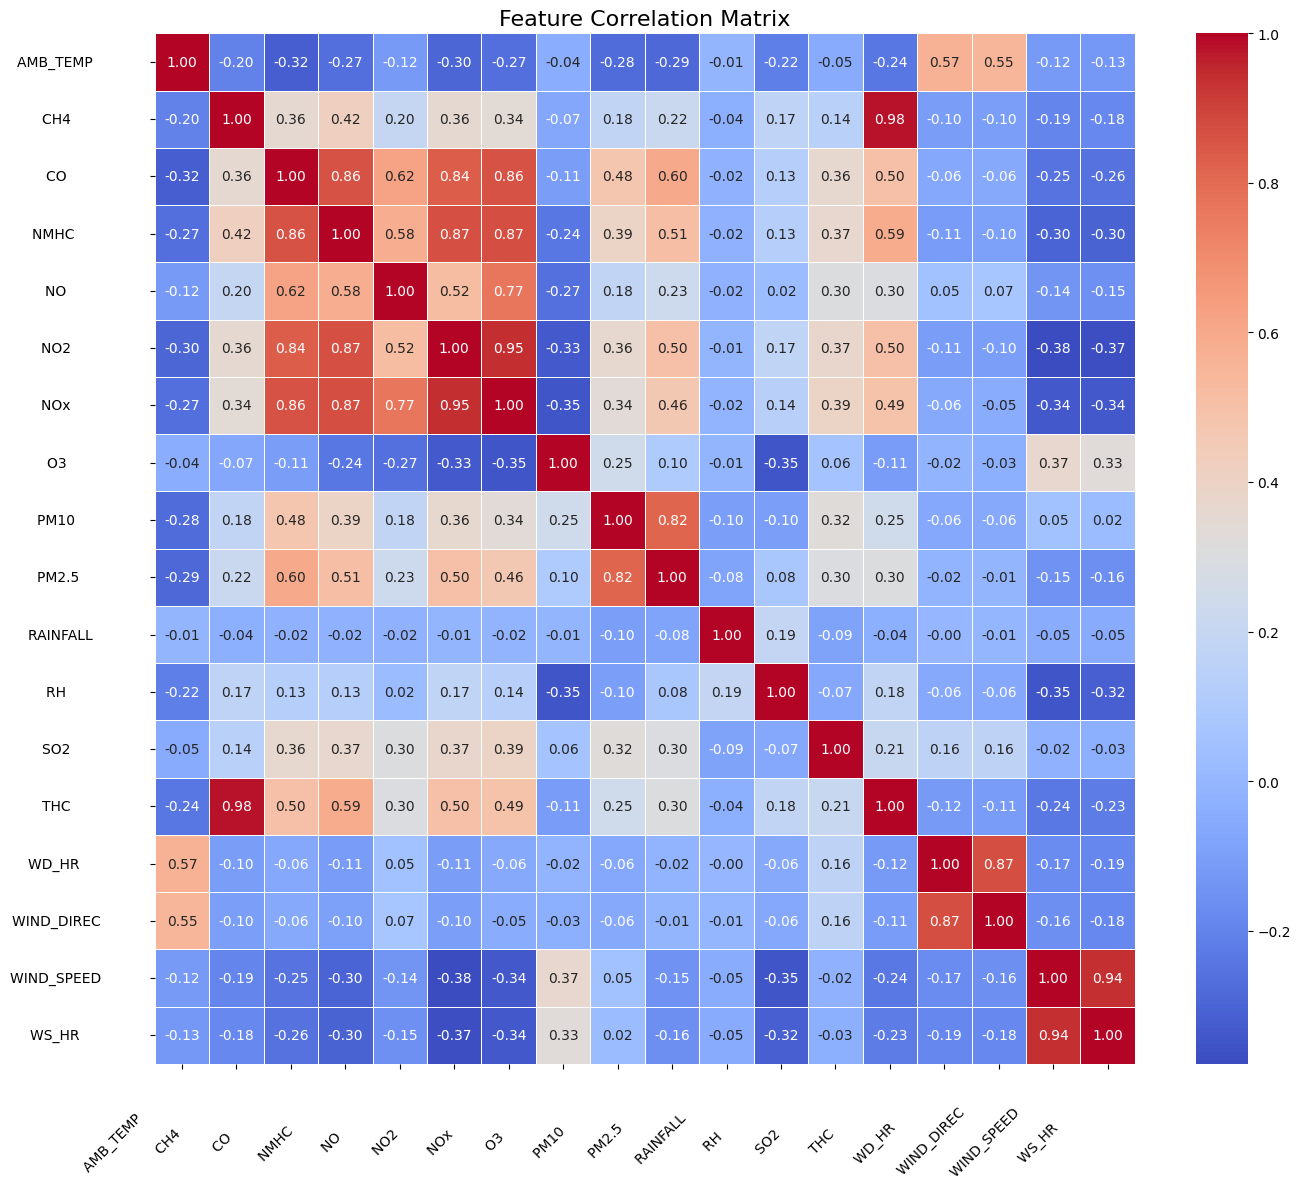

In [120]:
data = pd.read_csv('./train.csv', encoding = 'big5')
feature_names = data['ItemName'].unique()

data = data.iloc[:, 3:]
data[data == 'NR'] = 0
# Convert to numeric, forcing errors to NaN and then fill NaN with 0
data = data.apply(pd.to_numeric, errors='coerce').fillna(0)
raw_data = data.to_numpy(dtype=float)

num_days = len(raw_data) // 18
wide_df_data = []

for day in range(num_days):
            day_data_slice = raw_data[day*18 : (day+1)*18]
            day_data = pd.DataFrame(day_data_slice, index=feature_names)
            # Transpose the data so features become columns and hours become rows
            wide_df_data.append(day_data.T)

wide_df = pd.concat(wide_df_data).reset_index(drop=True)

correlation_matrix = wide_df.corr()

        # Create the heatmap for visualization
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to prevent labels from being cut off

# Save the plot to a file
plt.savefig('correlation_heatmap.png')
print("Successfully generated and saved 'correlation_heatmap.png'")
plt.show()

In [91]:
dayFlatten_data = np.empty([18,24*20*12])
for month in range(12):
  for day in range(20):
    dayFlatten_data[:, (month*20+day)*24:(month*20+day)*24+24] = raw_data[18*(20*month+day):18*(20*month+day+1), 0:24]

In [ ]:
x = np.empty([12*471, 18*9], dtype=float)
y = np.empty([12*471, 1], dtype=float)
for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                continue
            x[month * 471 + day * 24 + hour, :] = dayFlatten_data[:,day * 24 + hour : day * 24 + hour + 9].flatten()
            y[month * 471 + day * 24 + hour, 0] = dayFlatten_data[9, day * 24 + hour + 9]
print(x)
print(y)

(162,)
[[11.]
 [10.]
 [16.]
 ...
 [32.]
 [31.]
 [30.]]


# Split training and validation set

In [102]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_val: {x_val.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")

Shape of x_train: (4521, 162)
Shape of x_val: (1131, 162)
Shape of y_train: (4521, 1)
Shape of y_val: (1131, 1)


# Normalize

In [103]:
mean_x = np.mean(x_train, axis = 0)
std_x = np.std(x_train, axis = 0) 
for i in range(len(x_train)):
    for j in range(len(x_train[0])):
        if std_x[j] != 0:
            x_train[i][j] = (x_train[i][j] - mean_x[j]) / std_x[j]

for i in range(len(x_val)):
    for j in range(len(x_val[0])):
        if std_x[j] != 0:
            x_val[i][j] = (x_val[i][j] - mean_x[j]) / std_x[j]
x_train
x_val

array([[ 1.84109104,  2.17488408,  2.3753684 , ...,  2.32631056,
         1.73349356,  0.85602035],
       [ 0.09183268,  0.30038371,  0.39987227, ...,  0.35918252,
        -0.32328881, -0.41256645],
       [ 0.09183268,  0.08305034,  0.04807159, ...,  1.53945934,
         1.73349356,  1.73427275],
       ...,
       [-0.53680704, -0.56894979, -0.57434501, ...,  0.35918252,
        -0.12740478, -0.60773365],
       [-0.15415678, -0.32444974, -0.43903705, ..., -1.80465831,
        -1.79241908, -1.58356965],
       [-1.63009352, -1.30244994, -1.00733046, ...,  1.24439014,
         0.8520154 ,  1.24635475]])

# Training

Iteration 0: Train Loss = 17.2662, Val Loss = 17.1642
Iteration 100: Train Loss = 10.8042, Val Loss = 10.6672
Iteration 200: Train Loss = 8.6633, Val Loss = 8.5860
Iteration 300: Train Loss = 7.2093, Val Loss = 7.1693
Iteration 400: Train Loss = 6.1289, Val Loss = 6.1120
Iteration 500: Train Loss = 5.3029, Val Loss = 5.2995
Iteration 600: Train Loss = 4.6697, Val Loss = 4.6736
Iteration 300: Train Loss = 7.2093, Val Loss = 7.1693
Iteration 400: Train Loss = 6.1289, Val Loss = 6.1120
Iteration 500: Train Loss = 5.3029, Val Loss = 5.2995
Iteration 600: Train Loss = 4.6697, Val Loss = 4.6736
Iteration 700: Train Loss = 4.1902, Val Loss = 4.1974
Iteration 800: Train Loss = 3.8351, Val Loss = 3.8432
Iteration 900: Train Loss = 3.5796, Val Loss = 3.5869
Iteration 1000: Train Loss = 3.4015, Val Loss = 3.4072
Iteration 700: Train Loss = 4.1902, Val Loss = 4.1974
Iteration 800: Train Loss = 3.8351, Val Loss = 3.8432
Iteration 900: Train Loss = 3.5796, Val Loss = 3.5869
Iteration 1000: Train Los

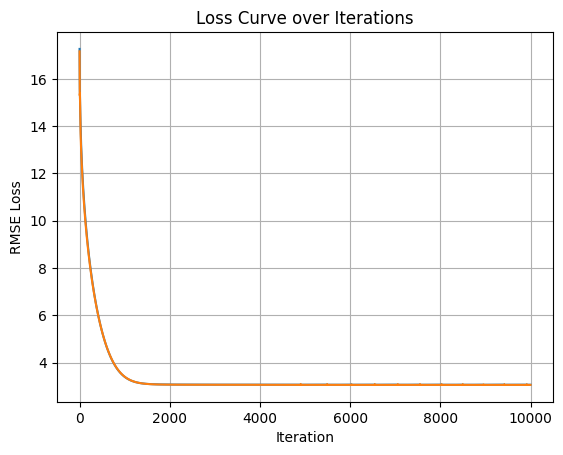

In [ ]:
hyper_parameter = {
    "learning_rate" : 0.01,
    # "learning_rate" : 1e-5,
    "n_iterations" : 10000,
    "gamma1" : 0.9,
    "gamma2" : 0.999,
    "eps" : 1e-8,
}

dim = 18 * 9 + 1
w = np.zeros([dim,1])

x_train_b = np.concatenate((np.ones((x_train.shape[0], 1)), x_train), axis=1)
x_val_b = np.concatenate((np.ones((x_val.shape[0], 1)), x_val), axis=1)
# print(x_b)
m = x_train_b.shape[0]
grad_momentum = np.zeros_like(w)
grad_RMSProp = np.zeros_like(w)

train_losses = []
val_losses = []

for i in range(hyper_parameter["n_iterations"]):
  train_loss = np.sqrt(np.mean(((x_train_b @ w) - y_train) ** 2))
  train_losses.append(train_loss)

  if np.isnan(train_loss) or np.isinf(train_loss):
    print(f"Stopping early due to numerical instability at iteration {i}")
    break
  
  val_loss = np.sqrt(np.mean(((x_val_b @ w) - y_val) ** 2))
  val_losses.append(val_loss)

  if i % 100 == 0:
    print(f"Iteration {i}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

  gradient = 2 / m * (x_train_b.T @ (x_train_b @ w - y_train))
  grad_momentum = hyper_parameter["gamma1"] * grad_momentum + (1 - hyper_parameter["gamma1"]) * gradient
  grad_RMSProp = np.sqrt(hyper_parameter["gamma2"] * (grad_RMSProp ** 2) + (1-hyper_parameter["gamma2"]) * (gradient ** 2))
  # w = w - hyper_parameter["learning_rate"] * grad_momentum
  w = w - hyper_parameter["learning_rate"] * grad_momentum / (grad_RMSProp + hyper_parameter["eps"])

print(f"Final Iteration {hyper_parameter['n_iterations']}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

np.save('weight.npy', w)

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Iteration")
plt.ylabel("RMSE Loss")
plt.title("Loss Curve over Iterations")
plt.grid()
plt.show()

In [108]:
testdata = pd.read_csv('./test.csv', header = None, encoding = 'big5')
testdata = testdata.iloc[:, 2:]
testdata[testdata == 'NR'] = 0
testdata = testdata.apply(pd.to_numeric, errors='coerce').fillna(0)
test_data = testdata.to_numpy()
test_x = np.empty([244, 18*9], dtype = float)
for i in range(244):
    test_x[i, :] = test_data[18 * i: 18* (i + 1), :].reshape(1, -1)
for i in range(len(test_x)):
    for j in range(len(test_x[0])):
        if std_x[j] != 0:
            test_x[i][j] = (test_x[i][j] - mean_x[j]) / std_x[j]
test_x = np.concatenate((np.ones([244, 1]), test_x), axis = 1).astype(float)
test_x

array([[ 1.        , 18.15134558, 17.74872552, ...,  0.49008059,
         0.18966442,  0.39311921],
       [ 1.        , 20.44483392, 20.34094213, ...,  0.49008059,
         0.69173451,  0.593647  ],
       [ 1.        , 20.34511704, 19.7427383 , ...,  1.29491828,
         1.49504666,  1.29549427],
       ...,
       [ 1.        , 19.64709885, 19.2442351 , ...,  1.79794184,
         1.79628871,  1.79681374],
       [ 1.        , 17.55304427, 17.15052168, ...,  2.3009654 ,
         2.39877283,  2.39839711],
       [ 1.        , 18.05162869, 17.4496236 , ...,  1.59673242,
         1.99711675,  2.09760543]])

In [109]:
# print(f"Shape of test_x: {test_x.shape}")
w = np.load('weight.npy')
ans_y = np.dot(test_x, w)
ans_y

array([[ 351.00503901],
       [ 386.21090479],
       [  71.87823134],
       [ 157.43362501],
       [ 296.42974159],
       [ 282.66593486],
       [ 145.87008571],
       [ 140.21828938],
       [ 434.33451418],
       [ 206.34077734],
       [ 446.16842813],
       [ 226.26672978],
       [ 321.70653483],
       [ 464.84567142],
       [ 209.71781729],
       [ 447.71572204],
       [ 353.10897126],
       [  75.69199929],
       [ 105.41535635],
       [ 197.09272452],
       [ 215.91879399],
       [  26.39507544],
       [ 198.21249726],
       [ 112.22508895],
       [ 133.56638118],
       [ 232.80521275],
       [  74.91365332],
       [1338.6690847 ],
       [ 257.19686089],
       [ 265.51723681],
       [ 129.93679218],
       [ 200.19833603],
       [ 494.30287028],
       [  -9.78725362],
       [  68.64483164],
       [ -34.20992061],
       [ 161.39260327],
       [ 197.5859172 ],
       [-158.8215311 ],
       [ 543.80279279],
       [ 397.8707592 ],
       [  50.259

In [110]:
import csv
with open('submit.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['index', 'answer']
    print(header)
    csv_writer.writerow(header)
    for i in range(244):
        row = ['index_' + str(i), ans_y[i][0]]
        csv_writer.writerow(row)
        print(row)

['index', 'answer']
['index_0', np.float64(351.0050390137378)]
['index_1', np.float64(386.210904787326)]
['index_2', np.float64(71.87823134274161)]
['index_3', np.float64(157.43362501089368)]
['index_4', np.float64(296.4297415932917)]
['index_5', np.float64(282.6659348630374)]
['index_6', np.float64(145.87008571100512)]
['index_7', np.float64(140.21828937995184)]
['index_8', np.float64(434.33451417624315)]
['index_9', np.float64(206.34077734258875)]
['index_10', np.float64(446.1684281296445)]
['index_11', np.float64(226.26672977748427)]
['index_12', np.float64(321.706534826478)]
['index_13', np.float64(464.84567141940994)]
['index_14', np.float64(209.71781728992062)]
['index_15', np.float64(447.71572204392896)]
['index_16', np.float64(353.1089712640108)]
['index_17', np.float64(75.69199929246415)]
['index_18', np.float64(105.41535635347736)]
['index_19', np.float64(197.0927245191307)]
['index_20', np.float64(215.91879398643718)]
['index_21', np.float64(26.395075435885182)]
['index_22',